In [1]:
from utils import seed_torch
from train import main
import train_configs
import models
import sys
import torch
sys.path.append("LoFTR")
import torch
import cv2
import numpy as np
import matplotlib.cm as cm

from src.utils.plotting import make_matching_figure
from src.loftr import LoFTR, default_cfg

/home/kaor/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/home/kaor/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/home/kaor/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,
/home/kaor/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,
Downloading: "https://github.com/DagnyT/hardnet/raw/master/pretrained/train_liberty_with_aug/checkpoint_liberty_with_aug.pth" to /home/kaor/.cache/torch/hub/checkpoints/checkpoint_liberty_with_aug.pth


In [2]:
# !/home/kaor/.conda/envs/openmmlab/bin/python -m pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [41]:
matcher = LoFTR(config=default_cfg)
matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
matcher = matcher.cuda().eval()

In [140]:
def load_img_to_LoFTR(path):
    img0_raw = cv2.imread(f"{config1.data_root_path}/{path}", cv2.IMREAD_GRAYSCALE)
    img0_raw = cv2.resize(img0_raw, (640, 480))
    img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
    return img0
    
def get_match(img0,imgs =[],verbose=True):
    num = []
    conf = []
    for im in imgs:
        batch = {'image0': img0, 'image1': im}
        with torch.no_grad():
            matcher(batch)
            mkpts0 = batch['mkpts0_f'].cpu().numpy()
            mkpts1 = batch['mkpts1_f'].cpu().numpy()
            mconf = batch['mconf'].cpu().numpy()
            num.append(len(mconf))
            conf.append(mconf.mean())
        if verbose:
            color = cm.jet(mconf, alpha=0.7)
            text = [
                'LoFTR',
                'Matches: {}'.format(len(mkpts0)),
            ]
            fig = make_matching_figure((img0.cpu().numpy()[0,0]*255).astype(np.uint8), (im.cpu().numpy()[0,0]*255).astype(np.uint8), mkpts0, mkpts1, color, mkpts0, mkpts1, text)
            
    return num,conf

In [5]:
# !/home/kaor/.conda/envs/openmmlab/bin/python -m pip install -U timm

In [44]:
config1 = train_configs.config21b6.config
# config2 = train_configs.config10.config
seed_torch(config1.seed)

In [7]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/home/kaor/.conda/envs/openmmlab/bin/python
3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)


In [8]:
import torch
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from models.eff import get_model
from runner import *
from post_processing import *
from datasets import *
import bz2
import pickle
import _pickle as cPickle

def compressed_pickle(title, data):
    with bz2.BZ2File(title + '.pbz2', 'w') as f:
        cPickle.dump(data, f)
        
def decompress_pickle(file):
     data = bz2.BZ2File(file, 'rb')
     data = cPickle.load(data)
     return data

In [129]:
train = pd.read_csv(config1.kfold_csv)
test = pd.read_csv('../../whale/sample_submission.csv')

/home/kaor/.local/lib/python3.7/site-packages/pandas/core/indexes/base.py:459: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
/home/kaor/.local/lib/python3.7/site-packages/pandas/core/indexes/base.py:459: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, n

In [130]:
train

,image,species,individual_id,classes,classes_species,fold,count_species,count_individual_id
0,8c684c7d3b5f1e.jpg,dusky_dolphin,0013f1f5f2f0,0,8,-1,3139,1
1,c6d687b5b7726d.jpg,dusky_dolphin,001618e0a31e,1,8,-1,3139,1
2,25c64edf562a73.jpg,dusky_dolphin,0022256f1506,6,8,-1,3139,1
3,8c4d54ac61ad86.jpg,dusky_dolphin,00bea66426f7,34,8,-1,3139,1
4,1a9607e5941548.jpg,dusky_dolphin,00e6b842274b,44,8,1,3139,3
...,...,...,...,...,...,...,...,...
51028,206dcfbb2ded4f.jpg,frasiers_dolphin,c850b153e202,12192,11,-1,14,1
51029,d3138efa8ad852.jpg,frasiers_dolphin,d30a0df2570c,12855,11,-1,14,1
51030,b0798ddfe1409f.jpg,frasiers_dolphin,db741f696fc0,13366,11,-1,14,1
51031,2426a2a1c36d96.jpg,frasiers_dolphin,ebdbc40f5a23,14383,11,-1,14,1


In [131]:
data = decompress_pickle(config1.save_dir+"exp16v6sampler_fold0.pbz2")

In [132]:
df = pd.concat([train,pd.DataFrame(data['emb_val'])],1)

/home/kaor/.local/lib/python3.7/site-packages/pandas/core/indexes/base.py:459: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


In [143]:
df_train = df[df.fold>0]
df_val = df[df.fold<1]
df_val.reset_index(drop=True,inplace=True)
df_train.reset_index(drop=True,inplace=True)

In [144]:
targets = df_train['classes'].values

In [145]:
vals, inds = get_topk_cossim_sub(df_val.values[:,8:].astype(float),df_train.values[:,8:].astype(float), k=1500)
vals=vals.cpu().numpy()
inds=inds.cpu().numpy()
labels = np.concatenate([targets[inds[:,i]].reshape(-1,1) for i in range(inds.shape[1])], axis=1)

100%|██████████| 276/276 [00:00<00:00, 625.03it/s]


In [273]:
new_id = []
old_id = []
fold = list(df_val.fold)
for row in range(len(vals)):
    if fold[row]==-1:
        new_id.append(vals[row][0])
    else:
        old_id.append(vals[row][0])
old_id = np.array(old_id)


In [274]:
def map_per_image(label, predictions):
    indexes = np.unique(predictions, return_index=True)[1]
    predictions = [predictions[index] for index in sorted(indexes)]
    t = np.where(np.array(predictions[:5]).astype(int)==label)[0]
    if len(t)>0:
        return 1 / (t[0] + 1)
    else:
        return 0.0

In [275]:
def find_best_th(th):
    M = []
    for row in range(len(vals)):
        if vals[row][0]<th:
            l = labels[row]
            l = np.insert(l,0,int(-1))
        else:
            l = labels[row]
            l = np.insert(l,1,int(-1))
        if fold[row]==-1:
            m = map_per_image(int(-1),l.astype(int))
        else:
            m = map_per_image(df_val.iloc[row]['classes'],l)
        M.append(m)
    M = np.array(M)
    return M.mean()
    

In [262]:
for th in range(65,75,1):
    score = find_best_th(th/100.0)
    print(f"th: {th}, score :{score}")

th: 65, score :0.8378313480809226
th: 66, score :0.8412346379277745
th: 67, score :0.8445528455284552
th: 68, score :0.8467082624314615
th: 69, score :0.8465664586878426
th: 70, score :0.8470202306674228
th: 71, score :0.846878426923804
th: 72, score :0.8448080922669691
th: 73, score :0.8418869351484212
th: 74, score :0.8385403667990168


In [277]:
M = []
for row in range(len(vals)):
    if fold[row]==-1:
        continue
    l = labels[row]
    m = map_per_image(df_val.iloc[row]['classes'],l)
    M.append(m)
M = np.array(M)
M.mean()

0.830187928014015

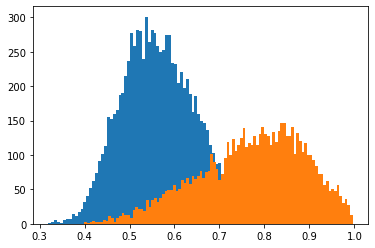

In [278]:
plt.hist(new_id,bins=100)
plt.hist(old_id[np.where(M==1.0)[0]],bins=100)
plt.show()

In [264]:
np.where(M==0.0)[0].shape

(2689,)

In [ ]:
plt.hist(new_id,bins=100)
plt.hist(old_id,bins=100)
plt.show()

In [137]:
# df_train[df_train.index.isin(inds[23][0:10])].classes,df_val[df_val.index.isin([23])].classes

[101, 115, 126, 138, 147, 181, 123, 155, 120, 99]

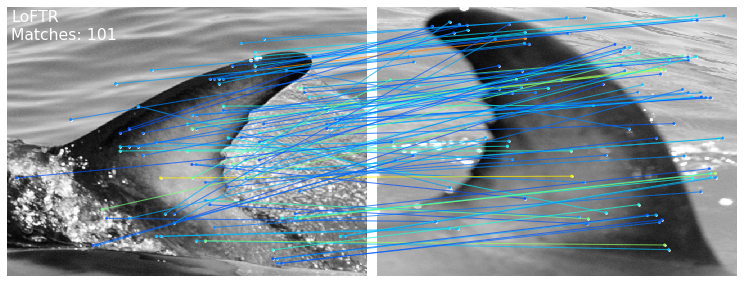

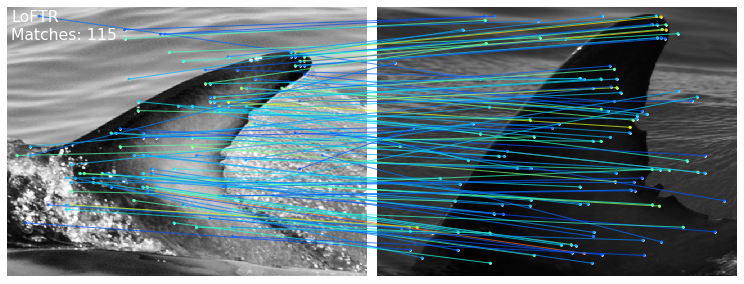

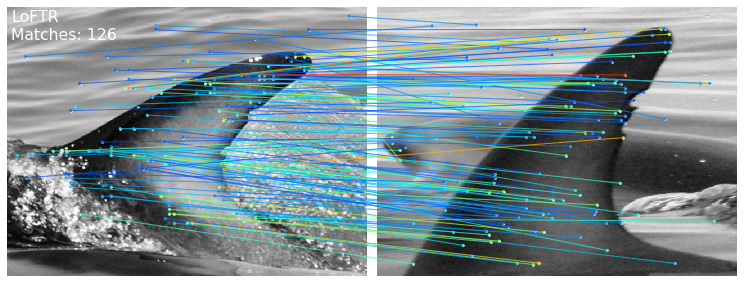

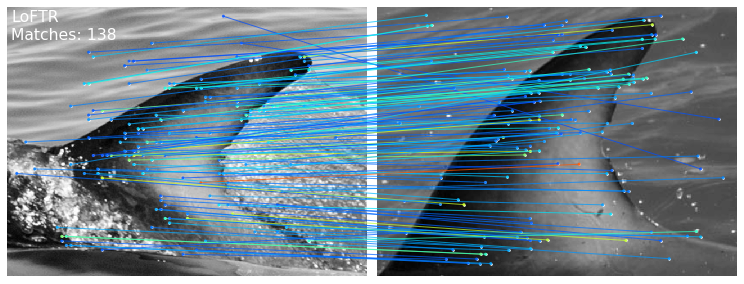

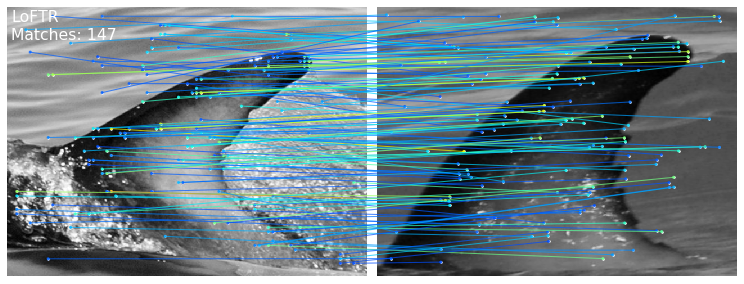

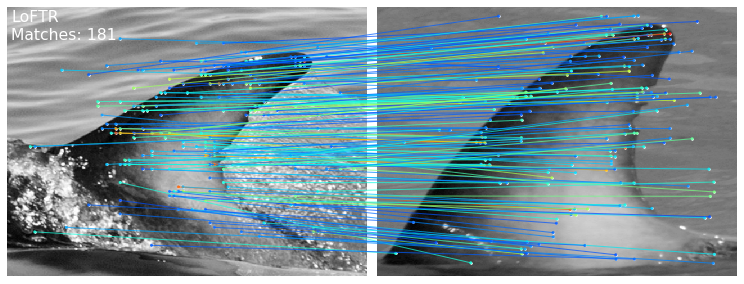

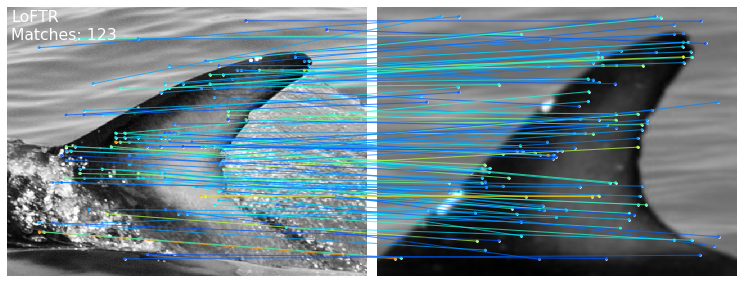

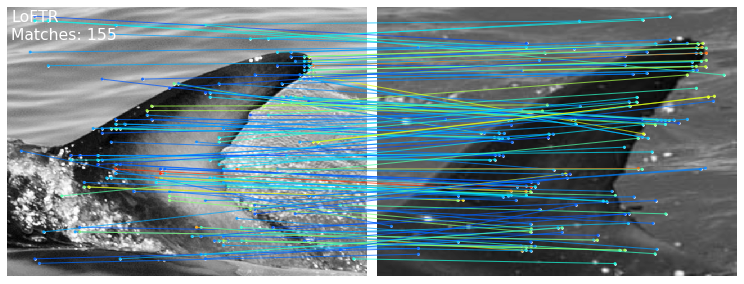

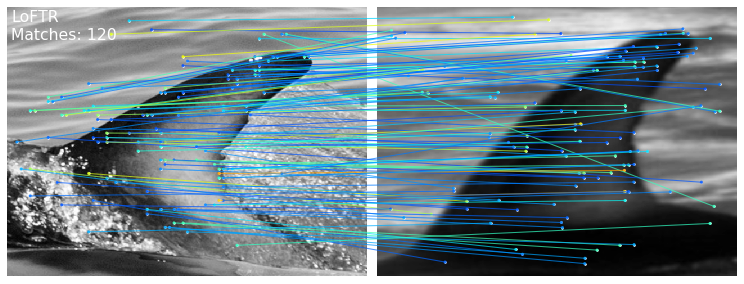

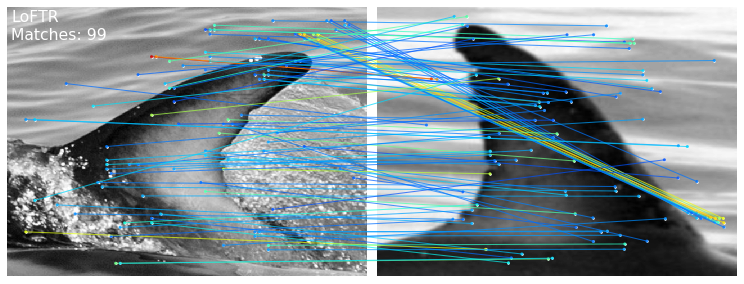

In [142]:
im0 = load_img_to_LoFTR(df_val.iloc[23]['image'])
imgs = [load_img_to_LoFTR(df_train.iloc[row]['image']) for row in inds[23][0:10]]
num,conf = get_match(im0,imgs)
num

In [120]:
conf

[0.31259257,
 0.32481447,
 0.31137672,
 0.3223855,
 0.3495651,
 0.32683465,
 0.33292332,
 0.30591422,
 0.34514433,
 0.30858082]

In [ ]:
# EMB_SIZE = 1024
# vals_blend = []
# labels_blend = []
# inds_blend = []
# for i in range(1):    
#     vals, inds = get_topk_cossim_sub(emb_test3[:,i*EMB_SIZE:(i+1)*EMB_SIZE], emb_val3[:,i*EMB_SIZE:(i+1)*EMB_SIZE], k=1500)
#     vals = vals.data.cpu().numpy()
#     inds = inds.data.cpu().numpy()
#     labels = np.concatenate([targets_val[inds[:,i]].reshape(-1,1) for i in range(inds.shape[1])], axis=1)
#     vals_blend.append(vals)
#     labels_blend.append(labels)
#     inds_blend.append(inds)
# df = []
# for i,t in enumerate(targets_filename):
#     res = []
#     cc= labels_blend[0][i]
#     for c in cc:
#         tl = name_dict[c]
#         if tl not in res:
#             res.append(tl)
#             if 'new_individual' not in res:
#                 res.append('new_individual')
#             if len(res)==5:
#                 break
#     df.append([t," ".join(res)])
# pd.DataFrame(df,columns=test.columns).to_csv(f"{config.exp_name}_ensemble.csv",index=False)

In [ ]:
th = vals_blend[0][:,0].mean()
vals_blend[0][:,0].mean()

In [ ]:
df = []
for i,t in enumerate(targets_filename):
    res = []
    cc= labels_blend[0][i]
    dist = vals_blend[0][i]
    for c,di in zip(cc,dist):
        tl = name_dict[c]
        if tl not in res:
            res.append(tl)
            if 'new_individual' not in res and di<th:
                res.append('new_individual')
            if len(res)==5:
                break
    df.append([t," ".join(res)])
pd.DataFrame(df,columns=test.columns).to_csv(f"{config.exp_name}_fold{fold}_th.csv",index=False)

In [ ]:
!nvidia-smi

In [ ]:
# pd.DataFrame(df,columns=test.columns)

In [ ]:
# plt.imshow(plt.imread("/home/kaor/whale/test_images/0485e977ceedaf.jpg")[1000:1200,1500:2000])

In [ ]:
# emb_test.shape

In [ ]:
# EMB_SIZE = 512
# vals_blend = []
# labels_blend = []
# inds_blend = []
# for i in range(1):    
#     vals, inds = get_topk_cossim_sub(emb_test[:,i*EMB_SIZE:(i+1)*EMB_SIZE], emb_val[:,i*EMB_SIZE:(i+1)*EMB_SIZE], k=1500)
#     vals = vals.data.cpu().numpy()
#     inds = inds.data.cpu().numpy()
#     labels = np.concatenate([targets_val[inds[:,i]].reshape(-1,1) for i in range(inds.shape[1])], axis=1)
#     vals_blend.append(vals)
#     labels_blend.append(labels)
#     inds_blend.append(inds)

In [ ]:
# name_dict = {}
# for row in train[['individual_id','classes']].drop_duplicates().values:
#     name_dict[row[1]]=row[0]
# # name_dict

In [ ]:
# cc = labels_blend[0][0]
# if cc[0]!=cc[1] or cc[1]==cc[2]:
#     print(cc[0:3])

In [ ]:
# df = []
# for i,t in enumerate(targets_filename):
#     res = []
#     cc= labels_blend[0][i]
#     for c in cc:
#         tl = name_dict[c]
#         if tl not in res:
#             res.append(tl)
#             if 'new_individual' not in res:
#                 res.append('new_individual')
#             if len(res)==5:
#                 break
#     df.append([t," ".join(res)])
# pd.DataFrame(df,columns=test.columns).to_csv(f"{config.exp_name}.csv",index=False)

In [ ]:
# from sklearn.neighbors import NearestNeighbors
# neigh = NearestNeighbors(n_neighbors=500,metric='cosine')
# neigh.fit(emb_val)

In [ ]:
# df = pd.DataFrame(df,columns=test.columns)
# # for row in df['predictions']:
# #     if "new" in row:
# #         print(row)
# df

In [ ]:
# for row in train['individual_id']:
#     if "new" in row:
#         print(row)